In [2]:
#import and install libraries

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch
print(torch.__version__)

2.5.1


In [5]:
#libraries
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



In [6]:
#load data

# Define image transformations (resize, convert to tensor, normalize)
# Define data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation (-20° to 20°)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for RGB Channels
])

In [7]:
# Standard transform for test set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#LOAD DATA

In [8]:
# path define
train_dir = r"C:\Users\sande\Desktop\Git\skin_app\notebook\data\archive\train"
test_dir = r"C:\Users\sande\Desktop\Git\skin_app\notebook\data\archive\test"


In [9]:
#load data

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [10]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
# Check the number of images
print(f"Train set: {len(train_data)} images")
print(f"Test set: {len(test_data)} images")

# Get class names
print("Classes:", train_data.classes)

Train set: 4806 images
Test set: 1006 images
Classes: ['Acne and Rosacea Photos', 'Bullous Disease Photos', 'Eczema Photos', 'Warts Molluscum and other Viral Infections']


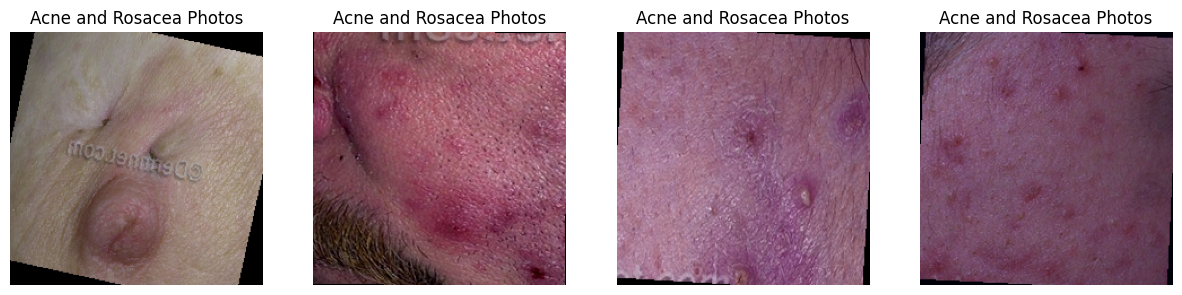

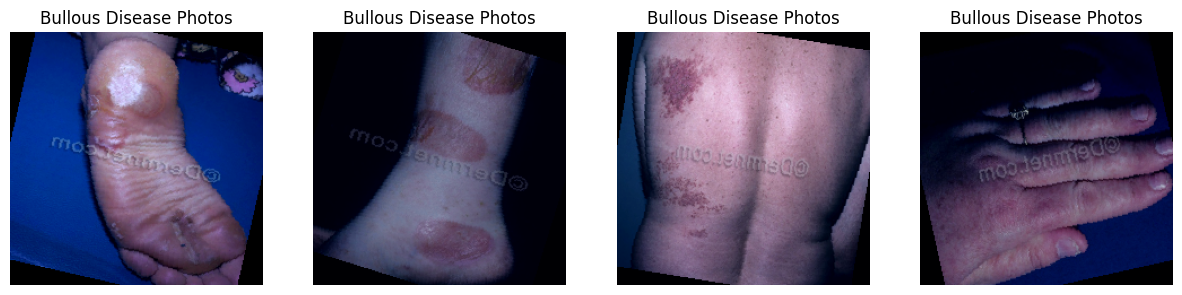

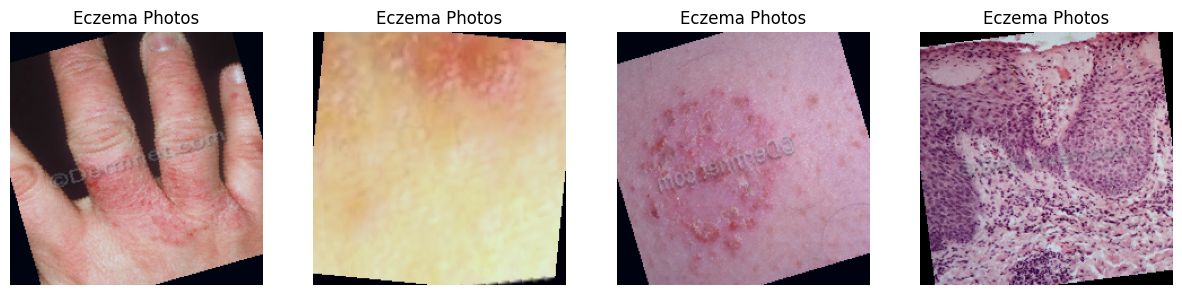

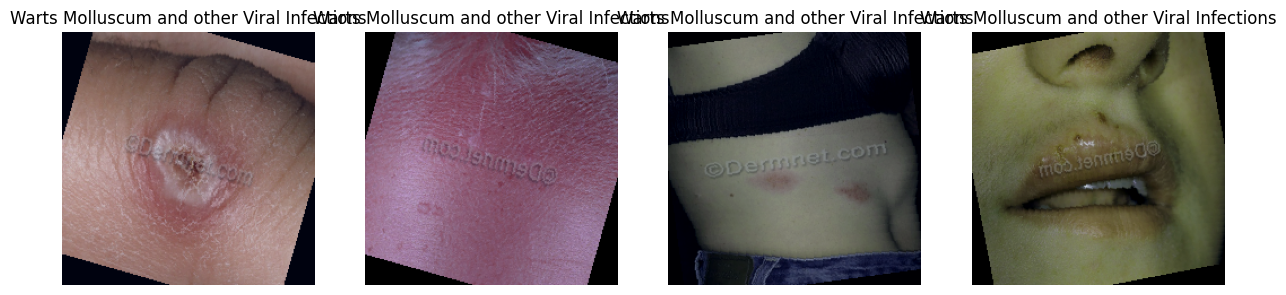

In [12]:
# Function to display images
def show_images_from_class(dataset, num_images=5):
    class_names = dataset.classes  # Get the class names
    for class_idx, class_name in enumerate(class_names):
        class_images = [dataset[i][0] for i in range(len(dataset)) if dataset[i][1] == class_idx]
        selected_images = random.sample(class_images, num_images)  # Randomly select images

        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, img_tensor in enumerate(selected_images):
            img = img_tensor.permute(1, 2, 0).numpy()  # Convert tensor to numpy array for displaying
            img = (img * 0.225) + 0.406  # Undo normalization
            img = img.clip(0, 1)  # Ensure pixel values are between 0 and 1
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f'{class_name}')

        plt.show()

# Display images from each category
show_images_from_class(train_data, num_images=4)

In [13]:
#EDA


# 1. Class distribution
class_count = pd.Series([label for _, label in train_data]).value_counts()

print(f'Class distribution:\n{class_count}')

# 2. Image size analysis (for the first 10 images in the dataset)
image_sizes = []
for i in range(10):  # Checking the first 10 images
    img, _ = train_data[i]
    image_sizes.append(img.shape[1:])  # (C, H, W), we are interested in (H, W)

# Convert to numpy array for analysis
image_sizes = np.array(image_sizes)

# Displaying the size of images
print(f'Image Sizes (Width x Height): {image_sizes}')

# 3. Basic statistics
num_images = len(train_data)
num_classes = len(train_data.classes)

print(f'Total number of images: {num_images}')
print(f'Number of classes: {num_classes}')
print(f'Class names: {train_data.classes}')



Class distribution:
0    1638
2    1634
3    1086
1     448
Name: count, dtype: int64
Image Sizes (Width x Height): [[224 224]
 [224 224]
 [224 224]
 [224 224]
 [224 224]
 [224 224]
 [224 224]
 [224 224]
 [224 224]
 [224 224]]
Total number of images: 4806
Number of classes: 4
Class names: ['Acne and Rosacea Photos', 'Bullous Disease Photos', 'Eczema Photos', 'Warts Molluscum and other Viral Infections']


In [ ]:
#model training and evaluation

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Modify last fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

# Train & Evaluate Model
train(model, train_loader, criterion, optimizer, epochs=60)
evaluate(model, test_loader)

c:\Users\sande\Desktop\Git\skin_app\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sande\Desktop\Git\skin_app\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/60, Loss: 1.0824, Accuracy: 56.89%
Epoch 2/60, Loss: 0.9106, Accuracy: 62.90%
Epoch 3/60, Loss: 0.8313, Accuracy: 66.87%
Epoch 4/60, Loss: 0.7786, Accuracy: 69.04%
Epoch 5/60, Loss: 0.7352, Accuracy: 71.68%
Epoch 6/60, Loss: 0.7193, Accuracy: 71.68%
Epoch 7/60, Loss: 0.7029, Accuracy: 72.33%
Epoch 8/60, Loss: 0.6333, Accuracy: 75.22%
Epoch 9/60, Loss: 0.6322, Accuracy: 75.38%
Epoch 10/60, Loss: 0.6133, Accuracy: 76.49%
Epoch 11/60, Loss: 0.5910, Accuracy: 76.80%
Epoch 12/60, Loss: 0.5669, Accuracy: 77.80%
Epoch 13/60, Loss: 0.5408, Accuracy: 78.59%
Epoch 14/60, Loss: 0.5233, Accuracy: 79.86%
Epoch 15/60, Loss: 0.4945, Accuracy: 81.11%
Epoch 16/60, Loss: 0.4872, Accuracy: 81.61%
Epoch 17/60, Loss: 0.4620, Accuracy: 82.36%
Epoch 18/60, Loss: 0.4383, Accuracy: 83.77%
Epoch 19/60, Loss: 0.4298, Accuracy: 83.75%
Epoch 20/60, Loss: 0.4030, Accuracy: 84.35%
Epoch 21/60, Loss: 0.4061, Accuracy: 84.64%


CNN ARCHITECTURE

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()

        # 1st Convolutional layer: input channels = 3 (RGB), output channels = 16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # 3x3 kernel
        self.relu1 = nn.ReLU()  # ReLU activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel

        # 2nd Convolutional layer: input channels = 16, output channels = 32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # Fully connected layer (for classification), assuming the image size is 32x32
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # 32 channels, 8x8 feature map size after pooling
        self.fc2 = nn.Linear(128, num_classes)  # Output size is num_classes

    def forward(self, x):
        # Pass the input through the network
        x = self.pool(self.relu1(self.conv1(x)))  # Convolution + ReLU + Max Pooling
        x = self.pool(self.relu2(self.conv2(x)))  # Convolution + ReLU + Max Pooling
        x = x.view(-1, 32 * 8 * 8)  # Flatten the output to feed into the fully connected layer
        x = self.relu1(self.fc1(x))  # Fully connected layer with ReLU activation
        x = self.fc2(x)  # Final output layer (no activation for raw class scores)
        return x


In [ ]:
model = SimpleCNN(num_classes=4)  # Example for a 4-class classification problem (e.g., CIFAR-10)


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


In [ ]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: compute the output
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass: compute the gradients
            loss.backward()

            # Update the model weights
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Print average loss after each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []  # To store all predictions
    all_labels = []  # To store all true labels
    
    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            
            all_preds.extend(predicted.cpu().numpy())  # Convert to numpy and add to list
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy and add to list
    
    # Convert lists to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Get Classification Report (precision, recall, f1-score)
    class_report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", class_report)
    print("\nConfusion Matrix:\n", conf_matrix)

    return accuracy, class_report, conf_matrix


In [ ]:
# After training the model, you can call evaluate to test it
evaluate(model, test_loader)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, test_dataset.classes)
